# Test implementation of the TDA approach for model selection

Using methods from TDA we want to implement the following pipline for assessing model selection:

1. Use the cubical homology to create a set of persistence diagrams from both the ideal case (just the data and labels), and the features post model inference with the labels.
2. Given each set of persistence diagrams create a persistance image - essentially a vector representation of topological information.
3. Compare the (Euclidean) distance between the vector for each model and the vector for the base case, with the shorter the distance suggesting better performance post fine tuning of a model.

This can be done using the giotto-ai library.

In [334]:
from typing import Callable, Iterable

import numpy as np

np.set_printoptions(edgeitems=30, linewidth=180)

from copy import copy
from scipy.stats import spearmanr
import requests
import torch
from datasets import Dataset, load_dataset
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from transformers import AutoImageProcessor, AutoModelForImageClassification, pipeline

## Import the data and models

In [367]:
model_name = "google/vit-base-patch16-224"
# model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=0)
classifier = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

In [300]:
dataset = load_dataset(
    "imagenet-1k", split="validation", token=True, streaming=True
)

In [4]:
def iter_extr(iterable, idx_c=0):
    for idx, iter in enumerate(iterable):
        if idx == idx_c:
            return iter

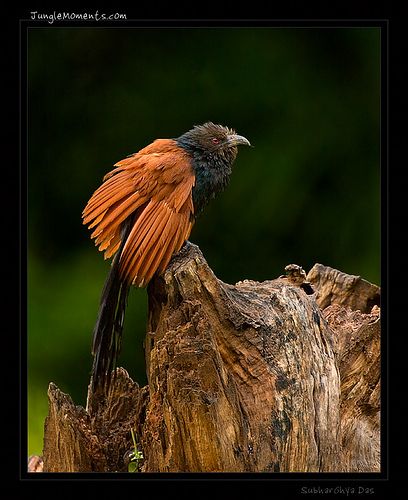

In [5]:
display(next(iter(dataset))['image'])

In [301]:
# Preprocess for the use in the models
def preprocess(examples):
    examples["pixel_values"] = [
        processor(image.convert("RGB"))["pixel_values"][0]
        for image in examples["image"]
    ]
    return examples


imgs = dataset.map(preprocess, remove_columns="image", batched=True, batch_size=1)
imgs = imgs.with_format("torch")

In [314]:
classifier(next(iter(imgs))['pixel_values'][None, :, :, :]).logits.argmax(-1).item()

91

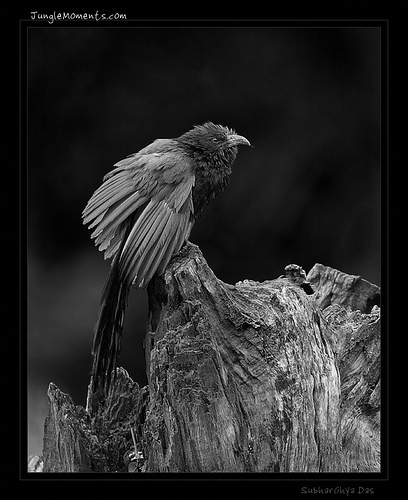

In [6]:
# TDA method requires Grayscale
from torchvision.transforms import Grayscale

display(Grayscale()(next(iter(dataset))['image']))

To get this to work all of the images have to be the same size, hence resizing them to 224 x 224 pixels

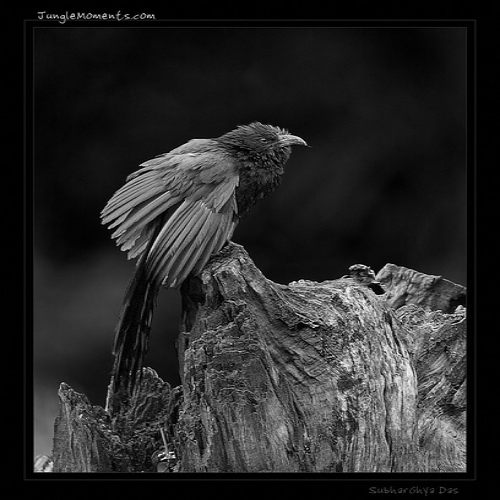

In [152]:
from torchvision.transforms import Resize

display(Resize((500, 500))(Grayscale()(next(iter(dataset))['image'])))

In [9]:
from torchvision.transforms import ToTensor

T = ToTensor()(Resize((224,224))(Grayscale()(next(iter(dataset))['image'])))
T.shape

torch.Size([1, 224, 224])

In [95]:
pixels = 224
num_labels = None
if num_labels is not None:
    pixels = num_labels

def tda_preprocess(examples):
    examples["pixel_values"] = [
        ToTensor()(Resize((pixels, pixels))(Grayscale()(image)))
        for image in examples["image"]
    ]
    return examples


tda_imgs = dataset.map(tda_preprocess, remove_columns="image", batched=True, batch_size=1)
tda_imgs = tda_imgs.with_format("torch")

In [15]:
next(iter(tda_imgs))['pixel_values'].shape

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


torch.Size([1, 224, 224])

Tom's reccommendation is to feed the homology object (diagram maker) (n,d) tensors of n data points where the each row either:

- (x_1, ..., x_n, y) OR
- (x_1, ..., x_n, f(x))

where x are the flattened pixel values of the original images, y is the ground truth label (typically just the integer is passed, but might be worth trying this with the one hot vectors instead) and f(x) are the features.

## TDA

Replacing the cubical homology method with the Vietoris Rips homology methd. This allows for images of different sizes, but according to Tom is incredibly slow to process...

The idea here being that I give it p (m, n+f_p) lists of m example arrays of (x_1, ..., x_n, f(x)) where x are the flattened pixel values from the images, f_p(x) is either the ground truth labels or the model labels/features (either should work).

In [335]:
from gtda import homology as hom
from gtda import diagrams 
from torch import flatten, cat, Tensor, reshape
from sklearn.preprocessing import OneHotEncoder

In [287]:
def pad_and_wrap_one_hot(one_hot, pix_val=224):
    """If the one hot vector is less than 224 in dimension then pad it to 224. If 
    greater than pad it to a multiple of 224 then wrap it.
    """
    if one_hot.shape[0] % pix_val == 0:
        return one_hot
    else:
        pad_vec = np.concatenate(
            (one_hot, np.zeros(pix_val - (one_hot.shape[0]%pix_val)))
            )
        pad_vec = pad_vec.reshape(1, pad_vec.shape[0] // pix_val, pix_val)
        return pad_vec

def one_tda_example(img, label, one_hot=False):
    if one_hot:
        return np.concatenate(
            (
                np.asarray(img),
                pad_and_wrap_one_hot(label, img.shape[2])
            ), axis = 1
        )
    else:
        return np.concatenate(
            (
                np.asarray(img),
                np.full((1,1,img.shape[1]), label)
            ), axis = 1
        )

def tda_probe_set_labs(n: int, img_iter: Iterable, one_hot=False):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.
    
    Args:
        - n (int): size of the probe set
        - img_iter: iterable dataset for TDA
    """
    # Work around for the one hot labels because I'm streaming the data here.
    if one_hot:
        labels = np.zeros(n)
        for idx, label in enumerate(img_iter):
            labels[idx] = label['label']
            if idx == n-1:
                break
        labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1,1))
        
    examples = []
    for idx, image in enumerate(img_iter):
        if one_hot:
            label = labels[idx]
        else:
            label = image['label']
        examples.append(one_tda_example(image['pixel_values'], label, one_hot))
        if idx == n-1:
            break
    return np.concatenate(examples, axis=0)

In [288]:
probe_set_labs = tda_probe_set_labs(10, tda_imgs, one_hot=True)
probe_set_labs.shape

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



(10, 225, 224)

The cubical homlogy requires a 2D array of pixel values for a grayscale image. 

In [289]:
cub_hom = hom.CubicalPersistence([0,1])

In [290]:
diag = cub_hom.fit_transform(probe_set_labs)

In [292]:
from gtda.plotting import plot_diagram

plot_diagram(diag[0])

In [293]:
diag.shape

(10, 8883, 3)

Now make some diagrams with features from the above model.

### Persistance images

From the diagrams make the persistance images. Initially just for the one.

In [295]:
per_img = diags.PersistenceImage()

In [296]:
img = per_img.fit_transform(diag)

In [297]:
img.shape

(10, 2, 100, 100)

In [298]:
per_img.fit_transform_plot(diag)

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000

Need to make sure the bounding boxes are the same size. Make the persistance diagram for all them.

## Questions:

1. Features or labels?

one hot wrap around technique:

In [137]:
vec = np.zeros(1000)
vec[220] = 1.

In [128]:
vec.shape[0] % 224

221

In [129]:
if vec.shape[0] % 224 != 0:
    pad_vec = np.concatenate((vec, np.zeros(224 - (vec.shape[0]%224))))

In [113]:
pad_vec = np.concatenate((vec, np.zeros(224 - (vec.shape[0]%224))))

In [134]:
pad_vec.reshape(1, pad_vec.shape[0] // 224, 224).shape

(1, 1, 224)

In [201]:
def pad_and_wrap_one_hot(one_hot, pix_val=224):
    """If the one hot vector is less than 224 in dimension then pad it to 224. If 
    greater than pad it to a multiple of 224 then wrap it.
    """
    if one_hot.shape[0] % pix_val == 0:
        return one_hot
    else:
        pad_vec = np.concatenate((one_hot, np.zeros(pix_val - (one_hot.shape[0]%pix_val))))
        pad_vec = pad_vec.reshape(1, pad_vec.shape[0] // pix_val, pix_val)
        return pad_vec

In [200]:
ohv = np.zeros(512)
ohv[351] = 1.
phv = np.concatenate((ohv, np.zeros(224 - (ohv.shape[0] % 224))))
print(phv.shape)
phv = phv.reshape(1, phv.shape[0] // 224, 224)
phv.shape


(672,)


(1, 3, 224)

In [190]:
pad_and_wrap_one_hot(ohv)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [138]:
pad_and_wrap_one_hot(vec)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Putting it together

Write full version with hyperparemeter choices:

1. Adjust pixel size for num_classes.
2. One hot vs class label.

If (1) is False and (2) is one hot then use wrap around for the vector, else just pad the class label as discussed above.

In [ ]:
def pad_and_wrap_one_hot(one_hot, pix_val=224):
    """If the one hot vector is less than 224 in dimension then pad it to 224. If 
    greater than pad it to a multiple of 224 then wrap it.
    """
    if one_hot.shape[0] % pix_val == 0:
        return one_hot
    else:
        pad_vec = np.concatenate(
            (one_hot, np.zeros(pix_val - (one_hot.shape[0]%pix_val)))
            )
        pad_vec = pad_vec.reshape(1, pad_vec.shape[0] // pix_val, pix_val)
        return pad_vec

def one_tda_example(img, label, one_hot=False):
    if one_hot:
        return np.concatenate(
            (
                np.asarray(img),
                pad_and_wrap_one_hot(label, img.shape[2])
            ), axis = 1
        )
    else:
        return np.concatenate(
            (
                np.asarray(img),
                np.full((1,1,img.shape[1]), label)
            ), axis = 1
        )

def tda_probe_set_labs(n: int, img_iter: Iterable, one_hot=False):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.
    
    Args:
        - n (int): size of the probe set
        - img_iter: iterable dataset for TDA
    """
    # Work around for the one hot labels because I'm streaming the data here.
    if one_hot:
        labels = np.zeros(n)
        for idx, label in enumerate(img_iter):
            labels[idx] = label['label']
            if idx == n-1:
                break
        labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1,1))
        
    examples = []
    for idx, image in enumerate(img_iter):
        if one_hot:
            label = labels[idx]
        else:
            label = image['label']
        examples.append(one_tda_example(image['pixel_values'], label, one_hot))
        if idx == n-1:
            break
    return np.concatenate(examples, axis=0)

In [337]:
def tda_probe_set_preds(n: int, 
                        tda_img_iter: Iterable, 
                        inf_img_iter: Iterable, 
                        classifier,
                        one_hot=False,
                        ):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.
    
    Args:
        - n (int): size of the probe set
        - tda_img_iter: iterable dataset for TDA
        - inf_img_iter: iterable dataset for inference
        - one_hot: use one hot encoding or just integer labesl
    """
    # Work around for collecting predicted classes as streaming data
    preds = np.zeros(n)
    for idx, image in enumerate(inf_img_iter):
        preds[idx] = classifier(
            image['pixel_values'][None, :, :, :]
            ).logits.argmax(-1).item()
        if idx == n-1:
            break
    
    if one_hot:
        preds = OneHotEncoder(sparse_output=False).fit_transform(preds.reshape(-1, 1))
        
    examples = []
    for idx, image in enumerate(tda_img_iter):
        examples.append(one_tda_example(image['pixel_values'], preds[idx], one_hot))
        if idx == n-1:
            break
    return np.concatenate(examples, axis=0)

In [338]:
preds_examples = tda_probe_set_preds(10, tda_imgs, imgs, classifier, one_hot=True)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [343]:
def tda_pipeline(tda_examples_set):
    cub_hom = hom.CubicalPersistence([0,1])
    return cub_hom.fit_transform(tda_examples_set)
    # print(diags.shape)
    # per_img = diagrams.PersistenceImage()
    # return per_img.fit_transform(diags)

In [344]:
preds_diags = tda_pipeline(preds_examples)

In [345]:
preds_diags.shape

(10, 8883, 3)

In [346]:
labs_examples = tda_probe_set_labs(10, tda_imgs, one_hot=True)

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [347]:
labs_diags = tda_pipeline(labs_examples)

In [348]:
labs_diags.shape

(10, 8883, 3)

In [354]:
per_img = diagrams.PersistenceImage()
all_imgs = per_img.fit_transform(
    np.concatenate((labs_diags, preds_diags), axis=0)
)

In [355]:
np.linalg.norm(all_imgs[:10, :, :, :] - all_imgs[10:, :, :, :])

298.2457145488734

## An Attempt at a full experiment pipeline for the purpose of running experiments....

In [37]:
from gtda import homology as hom
from gtda import diagrams as dgms
from torch import flatten, cat, Tensor, reshape
from sklearn.preprocessing import OneHotEncoder
from transformers import AutoImageProcessor, AutoModelForImageClassification
import numpy as np
from typing import Iterable
from datasets import Dataset, load_dataset
from torchvision.transforms import ToTensor, Resize, Grayscale
np.set_printoptions(edgeitems=30, linewidth=180)

def tda_preprocess(examples, pixels=224):
    examples["pixel_values"] = [
        ToTensor()(Resize((pixels, pixels))(Grayscale()(image)))
        for image in examples["image"]
    ]
    return examples

def pad_and_wrap_one_hot(one_hot, pix_val=224):
    """If the one hot vector is less than 224 in dimension then pad it to 224. If 
    greater than pad it to a multiple of 224 then wrap it.
    """
    if one_hot.shape[0] % pix_val == 0:
        return one_hot
    else:
        pad_vec = np.concatenate(
            (one_hot, np.zeros(pix_val - (one_hot.shape[0]%pix_val)))
            )
        pad_vec = pad_vec.reshape(1, pad_vec.shape[0] // pix_val, pix_val)
        return pad_vec

def one_tda_example(img, label, one_hot=False):
    if one_hot:
        return np.concatenate(
            (
                np.asarray(img),
                pad_and_wrap_one_hot(label, img.shape[2])
            ), axis = 1
        )
    else:
        return np.concatenate(
            (
                np.asarray(img),
                np.full((1,1,img.shape[1]), label)
            ), axis = 1
        )

# This should be one function with the other version in the script...
def tda_probe_set_labs(n: int, tda_img_iter: Iterable, one_hot=False):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.
    
    Args:
        - n (int): size of the probe set
        - img_iter: iterable dataset for TDA
    """
    # Work around for the one hot labels because I'm streaming the data here.
    if one_hot:
        labels = np.zeros(n)
        for idx, label in enumerate(tda_img_iter):
            labels[idx] = label['label']
            if idx == n-1:
                break
        labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1,1))
        
    examples = []
    for idx, image in enumerate(tda_img_iter):
        if one_hot:
            label = labels[idx]
        else:
            label = image['label']
        examples.append(one_tda_example(image['pixel_values'], label, one_hot))
        if idx == n-1:
            break
    return np.concatenate(examples, axis=0)

def tda_probe_set_preds(n: int, 
                        tda_img_iter: Iterable, 
                        inf_img_iter: Iterable, 
                        classifier,
                        one_hot=False,
                        ):
    """Create a probe set of representations for use in a TDA pipelin with the ground
    truth labels.
    
    Args:
        - n (int): size of the probe set
        - tda_img_iter: iterable dataset for TDA
        - inf_img_iter: iterable dataset for inference
        - one_hot: use one hot encoding or just integer labesl
    """
    # Work around for collecting predicted classes as streaming data
    preds = np.zeros(n)
    for idx, image in enumerate(inf_img_iter):
        preds[idx] = classifier(
            image['pixel_values'][None, :, :, :]
            ).logits.argmax(-1).item()
        if idx == n-1:
            break
    
    if one_hot:
        preds = OneHotEncoder(sparse_output=False).fit_transform(preds.reshape(-1, 1))
        
    examples = []
    for idx, image in enumerate(tda_img_iter):
        examples.append(one_tda_example(image['pixel_values'], preds[idx], one_hot))
        if idx == n-1:
            break
    return np.concatenate(examples, axis=0)

def preprocess(examples, processor):
    """Preprocessor for inference
    """
    examples["pixel_values"] = [
        processor(image.convert("RGB"))["pixel_values"][0]
        for image in examples["image"]
    ]
    return examples

def model_diags(model_name, tda_img_iter, homology, **pars):
    """Instantiate a classfier, generate probe set
    """
    # instantiate classifier and processor
    print('loading classifier and processor')
    if 
    model_fn = AutoModelForImageClassification.from_pretrained(model_name)
    processor = AutoImageProcessor.from_pretrained(model_name)
    
    # preprocess dataset
    print('processing data')
    dataset = pars['dataset']
    fn_kwargs = {'processor': processor}
    imgs = dataset.map(preprocess, 
                       remove_columns="image", 
                       batched=True, 
                       batch_size=1, 
                       fn_kwargs=fn_kwargs)
    imgs = imgs.with_format("torch")
    
    # create probeset
    print('model probe set computation')
    probe_set = tda_probe_set_preds(
        pars['n_examples'],
        tda_img_iter,
        imgs,
        classifier,
        pars['one_hot_labels']
    )
    
    # return b,d,q diagrams
    print('model diags computation')
    return homology.fit_transform(probe_set)


def tda_metric(**pars):
    """Draft pipeline for TDA metric.
    
    Params:
        - dataset: dataset
        - n_examples: size of the probe set
        - num_classes: number of classes in dataset
        - models: list of tuples of model functions and processors
        - pixel_square: one side of pixel length to reshape images to
        - pxsquare_as_n_classes: resize size of images to be n_classes * n_classes
        - one_hot_labels: use one hot labels vs. integer labels in padding
        - model_features: use the features or the classifier
    """
    # TDA objects:
    cub_hom = hom.CubicalPersistence()
    per_img = dgms.PersistenceImage()
    
    print('loaded tda objects')
    
    # Start by creating the diagrams for the ground truths
    print('starting ground truth diagram computation')
    fn_kwargs = None
    if pars['pixel_square'] is not None:
        pixels = pars['pixel_square']
        if pars['pxsquare_as_n_classes']:
            pixels = pars['num_classes']
        fn_kwargs = {'pixels': pixels}
    tda_imgs = dataset.map(
        tda_preprocess, 
        remove_columns="image", 
        batched=True, 
        batch_size=1, 
        fn_kwargs=fn_kwargs
        )
    tda_imgs = tda_imgs.with_format("torch")
    print('tda image processing done!')
    print('starting computation of ground truth probe set')
    gtruth_probe_set = tda_probe_set_labs(
        pars['n_examples'],
        tda_imgs,
        pars['one_hot_labels']
    )
    print('ground truth probe set completed')
    print('computing ground truth diagrams from probe set')
    diags = cub_hom.fit_transform(gtruth_probe_set)
    diags_shape = diags.shape
    print(f'ground truth diagrams computed, with shape {diags_shape}')
    
    # Create diagrams for each model and append to diags
    print('starting computation of model diagrams')
    for model in pars['models']:
        print(f'computing diagrams for {model}')
        model_diags = classifier_diags(model, tda_imgs, cub_hom, **pars)
        print(f'model diags shape {model_diags.shape}')
        # assert model_diags.shape == diags.shape, 'Diagram dimensions do not match!'
        diags = np.concatenate((diags, model_diags), axis=0)
    print('done with model diag computations')
    
    
    # Compute persistance image for entire set
    print('computing persistance image')
    perst_img = per_img.fit_transform(diags)
    
    # Compute metric from this
    print('computing metrics')
    results = {}
    base_img = perst_img[:pars['n_examples'], :, :, :]
    for idx, model in enumerate(pars['models']):
        print(f"indices for comparison: {(idx+1)*pars['n_examples']} to {(idx+2)*pars['n_examples']}")
        results[model] = np.linalg.norm(
            base_img - perst_img[
                (idx+1)*pars['n_examples']:(idx+2)*pars['n_examples'], :, :, :
                    ]
        )
    return results, perst_img
    

In [38]:
# Test the pipeline:
dataset = load_dataset(
    "imagenet-1k", split="validation", token=True, streaming=True
)
print('Loaded dataset!')

params = {
    'dataset': dataset,
    'n_examples': 10,
    'n_classes': 1000,
    'models': ["google/vit-base-patch16-224"],
    'pixel_square': None,
    'pxsquare_as_n_classes': False,
    'one_hot_labels': False
}

print('Starting metric computation!')
results, perst_img = tda_metric(**params)

Loaded dataset!
Starting metric computation!
loaded tda objects
starting ground truth diagram computation
tda image processing done!
starting computation of ground truth probe set


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


ground truth probe set completed
computing ground truth diagrams from probe set
ground truth diagrams computed, with shape (10, 8870, 3)
starting computation of model diagrams
computing diagrams for google/vit-base-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (10, 8870, 3)
done with model diag computations
computing persistance image
computing metrics
indices for comparison: 10 to 20


In [39]:
results


{'google/vit-base-patch16-224': 0.0}

In [27]:
# Try it with more models:
dataset = load_dataset(
    "imagenet-1k", split="validation", token=True, streaming=True
)
print('Loaded dataset!')

params = {
    'dataset': dataset,
    'n_examples': 10,
    'n_classes': 1000,
    'models': [
        "google/vit-base-patch16-224", 
        "microsoft/cvt-13",
        "facebook/deit-small-patch16-224",
        "facebook/deit-tiny-patch16-224",
        "facebook/deit-base-patch16-224"
        ],
    'pixel_square': None,
    'pxsquare_as_n_classes': False,
    'one_hot_labels': False
}

print('Starting metric computation!')
results, perst_img = tda_metric(**params)

Loaded dataset!
Starting metric computation!
loaded tda objects
starting ground truth diagram computation
tda image processing done!
starting computation of ground truth probe set
ground truth probe set completed
computing ground truth diagrams from probe set
ground truth diagrams computed, with shape (10, 8870, 3)
starting computation of model diagrams
computing diagrams for google/vit-base-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (10, 8870, 3)
computing diagrams for microsoft/cvt-13
loading classifier and processor


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (10, 8870, 3)
computing diagrams for facebook/deit-small-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (10, 8870, 3)
computing diagrams for facebook/deit-tiny-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (10, 8870, 3)
computing diagrams for facebook/deit-base-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (10, 8870, 3)
done with model diag computations
computing persistance image
computing metrics


In [28]:
results

{'google/vit-base-patch16-224': 0.0,
 'microsoft/cvt-13': 0.0,
 'facebook/deit-small-patch16-224': 0.0,
 'facebook/deit-tiny-patch16-224': 0.0,
 'facebook/deit-base-patch16-224': 0.0}

This works suspiciously well (though too well to use as a metric...), should check it's actually doing it correctly by replicating this step by step:

In [63]:
# Load dataset and params
dataset = load_dataset(
    "imagenet-1k", split="validation", token=True, streaming=True
)

pars = {
    'dataset': dataset,
    'n_examples': 1000,
    'n_classes': 1000,
    'models': [
        "google/vit-base-patch16-224", 
        "microsoft/cvt-13",
        "facebook/deit-small-patch16-224",
        "facebook/deit-tiny-patch16-224",
        "facebook/deit-base-patch16-224"
        ],
    'pixel_square': None,
    'pxsquare_as_n_classes': False,
    'one_hot_labels': False
}

In [64]:
# Preprocess dataset for use in tda diagrams and create tda diagrams
fn_kwargs = None
if pars['pixel_square'] is not None:
    pixels = pars['pixel_square']
    if pars['pxsquare_as_n_classes']:
        pixels = pars['num_classes']
    fn_kwargs = {'pixels': pixels}
tda_imgs = dataset.map(
    tda_preprocess, 
    remove_columns="image", 
    batched=True, 
    batch_size=1, 
    fn_kwargs=fn_kwargs
    )
tda_imgs = tda_imgs.with_format("torch")
# print('tda image processing done!')
# print('starting computation of ground truth probe set')
gtruth_probe_set = tda_probe_set_labs(
    pars['n_examples'],
    tda_imgs,
    pars['one_hot_labels']
)
# print('ground truth probe set completed')
# print('computing ground truth diagrams from probe set')
cub_hom = hom.CubicalPersistence()
diags = cub_hom.fit_transform(gtruth_probe_set)
diags_shape = diags.shape
diags.shape

/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


(1000, 13649, 3)

In [65]:
# Load data set and create diags
model = "facebook/deit-tiny-patch16-224"
cub_hom = hom.CubicalPersistence()
# print(f'computing diagrams for {model}')
model_diags = classifier_diags(model, tda_imgs, cub_hom, **pars)
# print(f'model diags shape {model_diags.shape}')
# assert model_diags.shape == diags.shape, 'Diagram dimensions do not match!'
# diags = np.concatenate((diags, model_diags), axis=0)
model_diags.shape

loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation


(1000, 13649, 3)

In [66]:
# Create persistance image
per_img = dgms.PersistenceImage()
full_diags = np.concatenate((diags, model_diags), axis=0)
perst_img = per_img.fit_transform(full_diags)
perst_img.shape

(2000, 2, 100, 100)

In [70]:
base_img = perst_img[:1000, :, :, :]
base_img.shape

(1000, 2, 100, 100)

In [71]:
comp_img = perst_img[1000:2000, :, :, :]
comp_img.shape

(1000, 2, 100, 100)

In [72]:
np.linalg.norm(base_img - comp_img)

11368.685605910974

Ok, well this behaviour is potentially to be expected for ImageNet, maybe if I expand the number of examples the classifiers will start to miss more often and that'll give a better representation:

In [45]:
# Try it with more models:
dataset = load_dataset(
    "imagenet-1k", split="validation", token=True, streaming=True
)
print('Loaded dataset!')

params = {
    'dataset': dataset,
    'n_examples': 1000,
    'n_classes': 1000,
    'models': [
        "google/vit-base-patch16-224", 
        "microsoft/cvt-13",
        "facebook/deit-small-patch16-224",
        "facebook/deit-tiny-patch16-224",
        "facebook/deit-base-patch16-224"
        ],
    'pixel_square': None,
    'pxsquare_as_n_classes': False,
    'one_hot_labels': False
}

print('Starting metric computation!')
results, perst_img = tda_metric(**params)

Loaded dataset!
Starting metric computation!
loaded tda objects
starting ground truth diagram computation
tda image processing done!
starting computation of ground truth probe set


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


ground truth probe set completed
computing ground truth diagrams from probe set
ground truth diagrams computed, with shape (1000, 13649, 3)
starting computation of model diagrams
computing diagrams for google/vit-base-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (1000, 13649, 3)
computing diagrams for microsoft/cvt-13
loading classifier and processor


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (1000, 13649, 3)
computing diagrams for facebook/deit-small-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (1000, 13649, 3)
computing diagrams for facebook/deit-tiny-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (1000, 13649, 3)
computing diagrams for facebook/deit-base-patch16-224
loading classifier and processor
processing data
model probe set computation


/Users/edable-heath/Library/Caches/pypoetry/virtualenvs/locomoset-yXOa9fJX-py3.10/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


model diags computation
model diags shape (1000, 13649, 3)
done with model diag computations
computing persistance image
computing metrics
indices for comparison: 1000 to 2000
indices for comparison: 2000 to 3000
indices for comparison: 3000 to 4000
indices for comparison: 4000 to 5000
indices for comparison: 5000 to 6000


In [46]:
results

{'google/vit-base-patch16-224': 0.0,
 'microsoft/cvt-13': 0.0,
 'facebook/deit-small-patch16-224': 0.0,
 'facebook/deit-tiny-patch16-224': 11368.685605910974,
 'facebook/deit-base-patch16-224': 0.0}